##Import ต่างๆ

In [98]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [99]:
import warnings
warnings.filterwarnings("ignore")

##ทำการ Read ไฟล์ csv ที่ทางเว็บให้มา

In [100]:
train_data = pd.read_csv("Data/train_ctrUa4K.csv")
test_data = pd.read_csv("Data/test_lAUu6dG.csv")

In [101]:
test_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [102]:
test_data_copy = test_data.copy()

In [103]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


##ขนาดของ Train และ Test

In [104]:
train_data.shape

(614, 13)

In [105]:
test_data.shape

(367, 12)

##ทำการเช็คข้อมูลและทำการ Clean ข้อมูลและทำการเติม Missing 


In [106]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


แยกประเภทของข้อมูล

In [107]:
cat_data = []

for index, type in enumerate(train_data.dtypes):
    if type == "object":
        cat_data.append(train_data.iloc[:, index])
cat_data = pd.DataFrame(cat_data).transpose()
cat_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,Urban,Y


In [108]:
train_data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

จะเห็นได้ว่าข้อมูลมี null อยู่ซึ่งอาจจะทำให้การ predict ผิดพลาดได้จึงต้องทำการจัดการกับข้อมูลเสียก่อน


In [110]:
del cat_data['Loan_ID']
del cat_data['Self_Employed']
for cat in cat_data.columns :
  if cat == 'Loan_Status' :
    pass
  else :
    train_data[cat]  = train_data[cat].fillna(train_data[cat].mode()[0])
    test_data[cat] = test_data[cat].fillna(test_data[cat].mode()[0])

In [111]:
train_data.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        30
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       48
Property_Area         0
Loan_Status           0
dtype: int64

LoanAmount fill ด้วย median

In [112]:
test_data.LoanAmount = test_data.LoanAmount.fillna(test_data["LoanAmount"].median())
train_data.LoanAmount = train_data.LoanAmount.fillna(train_data["LoanAmount"].median())

Loan_Amount_Term fill ด้วย bfill

In [113]:
train_data.Loan_Amount_Term = train_data.Loan_Amount_Term.fillna(method="bfill")
test_data.Loan_Amount_Term = test_data.Loan_Amount_Term.fillna(method="bfill")

Loan_Status fill ด้วยการดูค่าจาก Loan_Status เพราะว่าจาก EDA ทำให้ทราบว่าถ้า Credit_History กับ Loan_Status มีความสัมพันธ์กัน

In [114]:
train_data.loc[(train_data.Credit_History.isnull())&(train_data.Loan_Status==1),'Credit_History'] = 1
train_data.loc[(train_data.Credit_History.isnull()),'Credit_History'] = 0

test_data.Credit_History = test_data.Credit_History.fillna(method="bfill")

จาก EDA ทำให้ทราบว่าส่วนมากถ้าไม่ใช่อาชีพอิสระจะได้ credit_history = 1 

In [115]:
train_data.loc[(train_data.Self_Employed.isnull())&(train_data.Credit_History==1),'Self_Employed'] ='No'
train_data.loc[(train_data.Self_Employed.isnull()),'Self_Employed'] = 'Yes'

test_data.loc[(test_data.Self_Employed.isnull())&(test_data.Credit_History==1),'Self_Employed'] ='No'
test_data.loc[(test_data.Self_Employed.isnull()),'Self_Employed'] = 'Yes'

In [116]:
train_data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [117]:
test_data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

หลังจากการจัดการข้อมูแล้วจะทำให้เห็นวาไม่มีค่า Null แล้ว

##EDA


In [118]:
train_data_copy = train_data.copy()

<AxesSubplot:>

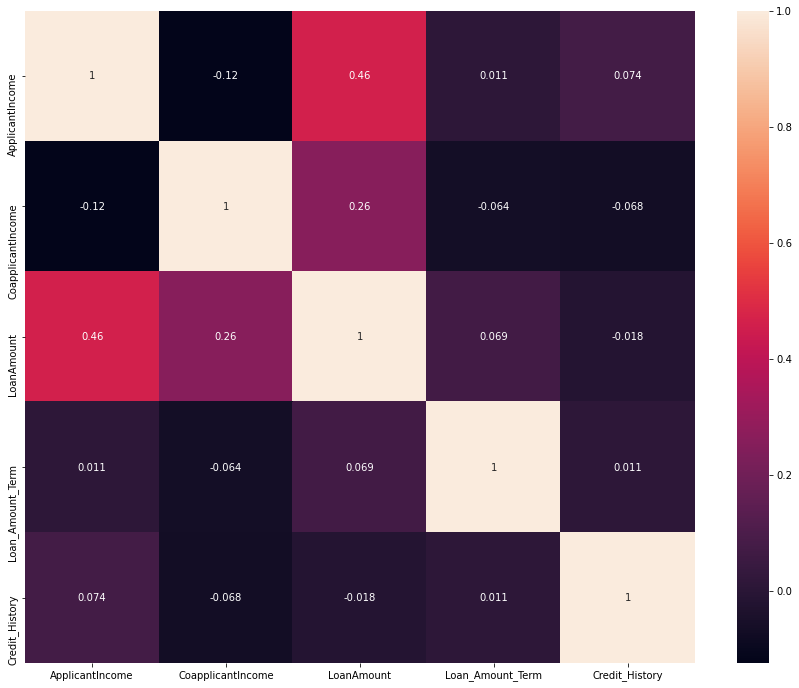

In [119]:
corr = train_data_copy.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True)

จากภาพจะทำให้เราเห็นว่ามีบาง Feature ที่มีความสัมพันธ์กันซึ่งมันจะเป็นข้อดีในตอน fill ข้อมูล

มาลองดูข้อมูลทั้งหมด

<AxesSubplot:xlabel='Dependents', ylabel='count'>

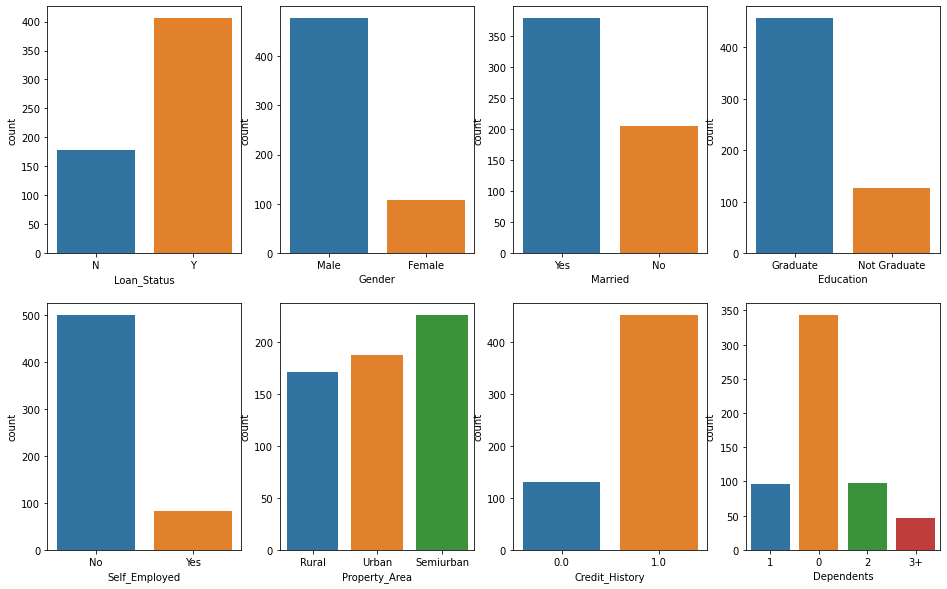

In [120]:
fig,ax = plt.subplots(2,4,figsize=(16,10))
sns.countplot('Loan_Status',data=train_data,ax=ax[0][0])
sns.countplot('Gender',data=train_data,ax=ax[0][1])
sns.countplot('Married',data=train_data,ax=ax[0][2])
sns.countplot('Education',data=train_data,ax=ax[0][3])
sns.countplot('Self_Employed',data=train_data,ax=ax[1][0])
sns.countplot('Property_Area',data=train_data,ax=ax[1][1])
sns.countplot('Credit_History',data=train_data,ax=ax[1][2])
sns.countplot('Dependents',data=train_data,ax=ax[1][3])

จากตารางทำให้เราเห็นว่า <br>
1.ยอมรับการกู้มากกว่าการปฏิเสธการกู้<br>
2.ชายมากกว่าหญิง<br>
3.คนแต่งงานมากกว่าคนที่ยังไม่แต่งงาน<br>
4.คนจบการศึกษามากกว่าคนที่ไม่จบ<br>
5.คนทำอาชีพอิสระน้อยกว่าคนทำงานทั่วไป<br>
6.คนที่อาศัยใน Semiurban มีมากกว่าอันอื่น <br>
7.คนมีประวัติการเงินที่ดีกว่าไม่ดี<br>
8.คนมีลูก 0 คนเยอะสุด<br>


<AxesSubplot:xlabel='Gender', ylabel='count'>

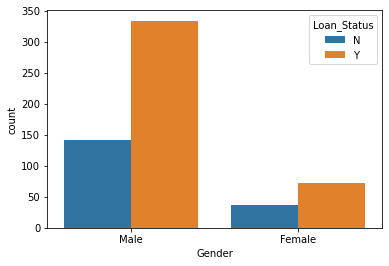

In [121]:
sns.countplot(train_data.Gender,hue=train_data.Loan_Status)

In [122]:
pd.crosstab(train_data.Gender, train_data.Loan_Status, margins = True)

Loan_Status,N,Y,All
Gender,,,
Female,36,72,108
Male,142,334,476
All,178,406,584


<AxesSubplot:xlabel='Credit_History', ylabel='count'>

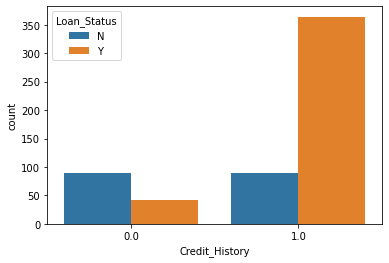

In [123]:
sns.countplot(train_data.Credit_History,hue=train_data.Loan_Status)

In [124]:
pd.crosstab(train_data.Credit_History,train_data.Loan_Status , margins=True)

Loan_Status,N,Y,All
Credit_History,,,
0.0,89,42,131
1.0,89,364,453
All,178,406,584


ถ้าประวัติเครดิตดีก็จะมีโอกาสที่จะกู้ได้มากกว่า ซึ่งควรนำไปทำเป็น Features

<AxesSubplot:xlabel='Self_Employed', ylabel='count'>

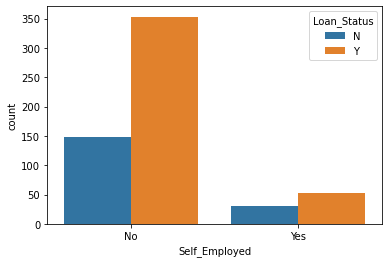

In [125]:
sns.countplot(train_data.Self_Employed,hue=train_data.Loan_Status)

In [126]:
pd.crosstab(train_data.Self_Employed , train_data.Loan_Status,margins = True)

Loan_Status,N,Y,All
Self_Employed,,,
No,148,353,501
Yes,30,53,83
All,178,406,584


เราจะเห็นได้ว่าถ้าเป็นอาชีพอิสระจะมีโอกาสได้กู้น้อยกว่า

<AxesSubplot:xlabel='Married', ylabel='count'>

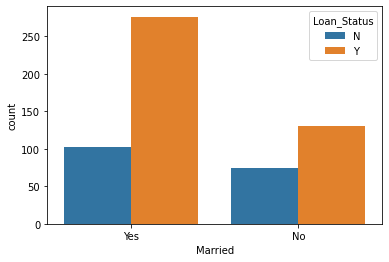

In [127]:
sns.countplot(train_data.Married,hue=train_data.Loan_Status)

In [128]:
pd.crosstab(train_data.Married, train_data.Loan_Status,margins = True)

Loan_Status,N,Y,All
Married,,,
No,75,130,205
Yes,103,276,379
All,178,406,584


<AxesSubplot:xlabel='Education', ylabel='count'>

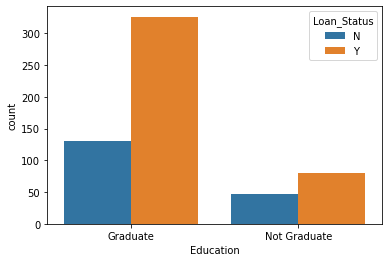

In [129]:
sns.countplot(train_data.Education,hue=train_data.Loan_Status)

In [130]:
pd.crosstab(train_data.Education, train_data.Loan_Status,margins = True)

Loan_Status,N,Y,All
Education,,,
Graduate,131,326,457
Not Graduate,47,80,127
All,178,406,584


<AxesSubplot:xlabel='Dependents', ylabel='count'>

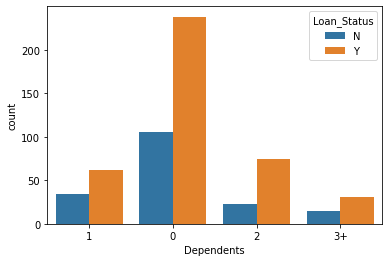

In [131]:
sns.countplot(train_data.Dependents,hue=train_data.Loan_Status)

In [132]:
pd.crosstab(train_data.Dependents, train_data.Loan_Status,margins = True)

Loan_Status,N,Y,All
Dependents,,,
0,106,238,344
1,34,62,96
2,23,75,98
3+,15,31,46
All,178,406,584


จาก Depdndent,Married,Education,Gender จะทำให้เห็นว่าค่าไม่ได้มีความแตกต่างกันมากแต่จะมีค่าที่แตกต่างกันมากๆคือ Credit_History และ Self_Employed ที่มีผลต่อ Loan_Status

งั้นแสดงว่า Credit_History และ Self_Employed มีความเกียวข้องหรือไม่มาลองพิสูจน์กัน

In [133]:
pd.crosstab(train_data.Self_Employed , train_data.Credit_History,margins = True)

Credit_History,0.0,1.0,All
Self_Employed,,,
No,108,393,501
Yes,23,60,83
All,131,453,584


สรุปสิ่งที่ได้คือ <br>
1.Credit_History และ Self_Employed ส่งผลต่อการ Loan <br>
2.Credit_History และ Self_Employed มีความสัมพันธ์กัน <br>
3.Feature อื่นๆไม่มีความสัมพันธ์กันมากเท่าไหร่ 

จากตารางข้างบนทำให้เห็นว่าถ้าเราทำงานอาชีพอิสระก็จะส่งผลต่อ Credit_History

##Preprocessing

In [134]:
cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 
        'Loan_Status', 'Dependents']
colsN = ['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount']
train_data = train_data.replace(['3+'],'3')

In [135]:
del train_data['Loan_ID']

for col in cols:
  train_data[col] = LabelEncoder().fit_transform(train_data[col])

for i in colsN :
  train_data[i] = StandardScaler().fit_transform(train_data[[i]])


train_data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,1,1,1,0,0,-0.090565,-0.049767,-0.182043,0.267607,1.0,0,0
2,1,1,0,0,1,-0.491040,-0.556449,-1.066324,0.267607,1.0,2,1
3,1,1,0,1,0,-0.596535,0.235830,-0.296144,0.267607,1.0,2,1
4,1,0,0,0,0,0.267915,-0.556449,0.003370,0.267607,1.0,2,1
5,1,1,2,0,1,0.120424,0.853391,1.800456,0.267607,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,-0.516339,-0.556449,-0.995011,0.267607,1.0,0,1
610,1,1,3,0,0,-0.211239,-0.556449,-1.437151,-2.539864,1.0,0,1
611,1,1,1,0,0,0.792099,-0.475810,1.600780,0.267607,1.0,2,1
612,1,1,2,0,0,0.668390,-0.556449,0.659449,0.267607,1.0,2,1


In [136]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 1 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             584 non-null    int32  
 1   Married            584 non-null    int32  
 2   Dependents         584 non-null    int32  
 3   Education          584 non-null    int32  
 4   Self_Employed      584 non-null    int32  
 5   ApplicantIncome    584 non-null    float64
 6   CoapplicantIncome  584 non-null    float64
 7   LoanAmount         584 non-null    float64
 8   Loan_Amount_Term   584 non-null    float64
 9   Credit_History     584 non-null    float64
 10  Property_Area      584 non-null    int32  
 11  Loan_Status        584 non-null    int32  
dtypes: float64(5), int32(7)
memory usage: 59.5 KB


In [137]:
colsT = ['Gender', 'Married', 'Education', 'Dependents','Property_Area','Self_Employed']

In [138]:
del test_data['Loan_ID']

test_data = test_data.replace(['3+'],'3') # เพราะมันอ่านไม่เข้าใจ
for col in colsT:
  test_data[col] = LabelEncoder().fit_transform(test_data[col])

scaler=StandardScaler()
for i in colsN :
  test_data[i] = StandardScaler().fit_transform(test_data[[i]])

test_data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

##Model Building

In [139]:
X = train_data.drop(['Loan_Status'], axis = 1 )
y = train_data['Loan_Status']

X_train ,X_test , y_train , y_test = train_test_split(X , y , test_size = 0.20 , random_state =0)

In [140]:
!pip3 install catboost

In [141]:
from catboost import CatBoostClassifier
logmodel = CatBoostClassifier().fit(X_train , y_train)
pred_l = logmodel.predict(X_test)
acc_l = accuracy_score(y_test , pred_l)*100
acc_l

Learning rate set to 0.007443
0:	learn: 0.6901412	total: 5.41ms	remaining: 5.4s
1:	learn: 0.6868555	total: 7.46ms	remaining: 3.72s
2:	learn: 0.6833994	total: 10ms	remaining: 3.34s
3:	learn: 0.6803348	total: 13.3ms	remaining: 3.31s
4:	learn: 0.6770379	total: 16.2ms	remaining: 3.23s
5:	learn: 0.6740616	total: 18.2ms	remaining: 3.02s
6:	learn: 0.6714497	total: 20.4ms	remaining: 2.9s
7:	learn: 0.6688121	total: 22.3ms	remaining: 2.76s
8:	learn: 0.6657739	total: 24.2ms	remaining: 2.67s
9:	learn: 0.6629444	total: 26.1ms	remaining: 2.59s
10:	learn: 0.6598155	total: 27.7ms	remaining: 2.49s
11:	learn: 0.6571790	total: 29.1ms	remaining: 2.4s
12:	learn: 0.6544237	total: 30.9ms	remaining: 2.35s
13:	learn: 0.6521609	total: 32.9ms	remaining: 2.32s
14:	learn: 0.6493824	total: 34.5ms	remaining: 2.27s
15:	learn: 0.6464239	total: 35.9ms	remaining: 2.21s
16:	learn: 0.6436844	total: 37.6ms	remaining: 2.17s
17:	learn: 0.6408694	total: 44.5ms	remaining: 2.43s
18:	learn: 0.6383103	total: 46.8ms	remaining: 2.4

72.64957264957265

In [142]:
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, y_train)
importances = pd.DataFrame({'Features':X_train.columns,'Importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('Importance',ascending=False).set_index('Features')
importances.head(11) 

,Importance
Features,
ApplicantIncome,0.228
LoanAmount,0.214
Credit_History,0.164
CoapplicantIncome,0.131
Property_Area,0.053
Dependents,0.050
Loan_Amount_Term,0.050
Married,0.033
Gender,0.029


In [143]:
importances = pd.DataFrame({'Features':X_train.columns,'Importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('Importance',ascending=False).set_index('Features')
importances.head(12) 

,Importance
Features,
ApplicantIncome,0.228
LoanAmount,0.214
Credit_History,0.164
CoapplicantIncome,0.131
Property_Area,0.053
Dependents,0.050
Loan_Amount_Term,0.050
Married,0.033
Gender,0.029


In [144]:
submission = pd.DataFrame({
        "Loan_ID": test_data_copy["Loan_ID"],
        "Loan_Status": logmodel.predict(test_data)
    })
submission['Loan_Status'] = submission['Loan_Status'].replace(1,'Y')
submission['Loan_Status'] = submission['Loan_Status'].replace(0,'N')

submission.to_csv("results.csv", encoding='utf-8', index=False)